<center> <h1>Thinning</h1> </center>

Simulate non homogeneous Poisson process.

## Required packages

In [1]:
import numpy as np
import math
from numpy.random import normal, uniform, poisson
import matplotlib.pyplot as pl

## Function for baseline

In [2]:
def f_Baseline(a,b,grille):
    lamb0 = np.zeros((grille.shape[0],))
    for k in np.arange(grille.shape[0]):
        lamb0[k] = (b**a)*a*(grille[k]**(a-1))
    return lamb0

## Time Varying Coefficients : $\beta(t)$

In [3]:
def beta_const(grille, param=1.):
    c = param
    beta_const = c*np.ones((grille.shape[0],))
    return beta_const
def beta_piecewise_const(grille, param=(4.,2.,1.)):
    c1,c2,rupture = param
    beta_2_const = c1*(grille<rupture)+c2*(grille>=rupture)
    return beta_2_const
def beta_linear(grille, param=(2.,-0.5)):
    ord_or,pente = param
    beta_lin = ord_or+pente*grille
    return beta_lin
def beta_quadratic(grille, param=(0.5)):
    a = param
    beta_quad = a*grille**2
    return beta_quad

## Time varying covariates : $X(t)$

Chaque X(k) suit une loi normale indépendante

In [4]:
def IndependantNormalX(n, p, grid, scaleX=0.5):
    X=[]
    n_points = grid.shape[0]
    for i in np.arange(n):
        X_i = np.vstack((normal(scale = scaleX, size = (p,n_points)).reshape(((p),n_points)))).T
        X.append(X_i)
    return X

## Brownian motion (Gaussian process)

In [5]:
def GaussianProcess(n, p, grid, start=0., mean=0., sd=1.):
    X=[]
    x_i = []
    n_points = grid.shape[0]
    for i in np.arange(n):
        last_x_i=normal(loc=mean+start, scale = sd, size = p)
        x_i_k = np.hstack(last_x_i)
        x_i = []
        #x_i.append(x_i_k)
        x_i = x_i_k
        #x_i = np.vstack((x_i,x_i_k))
        for k in range(len(grid)-1):
            increase = np.maximum(normal(loc=mean, scale = sd, size = p),0.)
            x_i_k = x_i_k + increase
            #x_i.append(x_i_k)
            x_i = np.vstack((x_i,x_i_k))
        X.append(x_i)
    return X

## $x_i(t) \beta(t)$

In [6]:
def f_xiBeta(X_i, beta, grid):
    n_i = X_i.shape[0]
    time_length = beta.shape[1]
    Xbeta_i=np.zeros(time_length)
    for t in np.arange(time_length):
        interval = 0
        condition = (grid[t] <= grid[0])
        while condition == False :
            interval += 1
            if interval < n_i:
                condition = (grid[t] <= grid[interval])
        if interval >= n_i:
                interval =n_i-1
                condition = True
        Xbeta_i[t]= np.dot(X_i[interval,:],beta[:,t])
    return Xbeta_i

## $\lambda_i(t) = \lambda_0(t) e^{X(t)\beta(t)}$

In [7]:
def lambda_i(baseline, X_i, beta, grid, nevents=1):
    Xbeta_i = f_xiBeta(X_i, beta, grid)
    lambda_i = nevents * baseline * np.exp(Xbeta_i)
    return lambda_i

## Thinning

In [8]:
def PPH(grid,C):
    t = np.max(grid)
    N_t = poisson(t*C)
    occurence = np.sort(uniform(0,t,N_t))
    return occurence

In [9]:
def thining_timevarying(baseline, X, beta, grid, nevents=1):
    n  = len(X)
    ppnh = []
    accept = []
    for i in np.arange(n):
        intensity_i = lambda_i(baseline, X[i], beta, grid, nevents)
        C = np.max(intensity_i)
        #print "nombre de points moyen", np.max(grid)*C
        Potential_Event = PPH(grid,C)
        N = len(Potential_Event)
        u = uniform(0,1,N)
        # find event intervall
        Potential_Event_Intervall = np.zeros(N)
        Potential_Event_Intensity = np.zeros(N)
        for j in range(N):
            for k in range(len(grid)):
                if grid[k] > Potential_Event[j]:
                    Potential_Event_Intervall[j] = k
                    Potential_Event_Intensity[j] = intensity_i[k]
                    break   
        #intensity_i = lambda_i(baseline, X[i], beta, Potential_Event_Intervall, nevents)
        probas = Potential_Event_Intensity/C
        accept = np.where(u <= probas)#.reshape((N,)))
        if len(accept[0]) == 0:
            # no event = event at t = infinity
            ppnh.append(np.array([math.inf]))
        else:    
            ppnh.append(Potential_Event[accept])
    return ppnh

## Format data

In [10]:
def format_data(NHPP, X, grid):
    p = len(X[0][0])
    s = np.array([])
    for j in range(p):
        s = np.append(s,"x"+str(j+1))
    data = np.array(["id", "event", "start", "stop"]+list(s))
    L = len(data)
    data = data.tolist()
    start = np.array(np.append(0, grid[:-1]))
    stop = grid
    for i in range(n):
        event_time = NHPP[i][0] # only one event
        for k in range(len(grid)):
            if start[k]<=event_time and event_time<stop[k]:
                data_i_k = np.append([i, 1, start[k], event_time], X[i][k])
                data.extend(data_i_k)
                break
            else :
                data_i_k = np.append([i, 0, start[k], stop[k]], X[i][k])
                data.extend(data_i_k)
    return np.reshape(np.asarray(data), (-1, L))

In [11]:
def format_data_multi_events(NHPP, X, grid, show_progress=True):
    from ipywidgets import FloatProgress
    from IPython.display import display
    if(show_progress):
        progress_bar = FloatProgress(min=0, max=len(NHPP), 
                                     description='Running:', bar_style='info',
                                     orientation='vertical')
        display(progress_bar)
    # We suppose multiple events can not occurd in the same time intervall
    p = len(X[0][0])
    s = np.array([])
    for j in range(p):
        s = np.append(s,"x"+str(j+1))
    data = np.array(["id", "event", "start", "stop"]+list(s))
    L = len(data)
    data = data.tolist()
    start = np.array(np.append(0, grid[:-1]))
    stop = grid
    for i in range(n):
        if(show_progress):
            progress_bar.value += 1
        event_number = 0
        event_time = np.append(NHPP[i], math.inf) # add infinity as final event
        for k in range(len(grid)):
            if start[k]<=event_time[event_number] and event_time[event_number]<stop[k]: # there is an event at this time
                # left part : before event
                data_i_k = np.append([i, 1, start[k], event_time[event_number]], X[i][k])
                data.extend(data_i_k)
                # right part : after event
                data_i_k = np.append([i, 0, event_time[event_number], stop[k]], X[i][k])
                data.extend(data_i_k)
                event_number = event_number + 1
            else :
                data_i_k = np.append([i, 0, start[k], stop[k]], X[i][k])
                data.extend(data_i_k)
    return np.reshape(np.asarray(data), (-1, L))

## Simulations

In [14]:
n = 100
p = 3 
grid = np.linspace(0.1,3,num=50)
baseline = f_Baseline(1.,1.,grid)
#baseline = f_Baseline(1.3,0.5,grid)
beta = np.vstack([beta_piecewise_const(grid, param=(0.4,0.2,1.)),
                  beta_linear(grid, param=(1.,-0.5)),
                  beta_quadratic(grid, param=(0.15))])
#beta = np.vstack([beta_piecewise_const(grid, param=(0.8,0.2,0.5)),
#                  beta_piecewise_const(grid, param=(0.0,0.6,2.)),
#                  beta_piecewise_const(grid, param=(-0.5,0.5,1.5))])

X = IndependantNormalX(n=n, p=p, grid=grid, scaleX=0.5)
#X = GaussianProcess(n=n, p=p, grid=grid, start=-1., mean=0., sd=0.1)#1./(len(grid)))
%time NHPP = thining_timevarying(baseline, X, beta, grid, nevents=1)

# Add noise/non informative variables
q = 7
X_noise = IndependantNormalX(n=n, p=q, grid=grid, scaleX=0.5)
X2=[]
X3 = []
n_points = grid.shape[0]
for i in range(n):
    tmp = []
    for k in range(len(grid)):
        tmp.extend(np.append(X[i][k], X_noise[i][k]))
    X_i = np.reshape(tmp,(n_points, p+q))
    X2 = np.vstack(X_i)
    X3.append(X2)

Wall time: 287 ms


In [12]:
#NHPP

## Terminal Event

In [16]:
len(X3[1][1])

10

In [17]:
#data = format_data(NHPP, X, grid)
data = format_data(NHPP, X3, grid)

## Repeated Events

In [18]:
#%time data = format_data_multi_events(NHPP, X, grid)
%time data = format_data_multi_events(NHPP, X3, grid)

Wall time: 522 ms


In [13]:
#data

## Write file

In [19]:
#nomfichier = "/data/simu_Gaussian_Process.csv"
#nomfichier = "/data/simu_independent_Gaussian.csv"
#nomfichier = "/data/simu_Gaussian_Process_Repeated_Events.csv"
#nomfichier = "/data/simu_Gaussian_Process_Repeated_Events_rupture.csv"
nomfichier = "/data/simu_with_non_informative_N1000.csv"
currentdir = %pwd    
import pandas as pd
df = pd.DataFrame(data) 
print(df.shape)
df.to_csv(currentdir+nomfichier,header=False,index=False)

(5323, 14)


## Write true coef

In [20]:
import pandas as pd
beta2 = pd.DataFrame(beta.T) 
beta2.insert(0,"grid",grid.T)
beta2.insert(1,"baseline", np.log(baseline.T))
beta2.columns = ['grid', 'baseline', 'beta1', 'beta2', 'beta3']
#beta2

In [21]:
import pandas as pd
currentdir = %pwd 
nomfichierBeta = "/data/beta.csv"
beta2.to_csv(currentdir+nomfichierBeta,header=False,index=False)

## Generate many sample for Monte-Carlo estimation

In [27]:
import pandas as pd
nb_sample = 100
n = 1000
p = 3
grid = np.linspace(0.1,3,num=50) #np.linspace(0.1,3,num=50)
baseline = f_Baseline(1.,1.,grid)
beta = np.vstack([beta_piecewise_const(grid, param=(0.4,0.2,1.)),
                  beta_linear(grid, param=(1.,-0.5)),
                  beta_quadratic(grid, param=(0.15))])

from ipywidgets import FloatProgress
from IPython.display import display
progress_bar = FloatProgress(min=0, max=nb_sample, 
                                     description='Running:', bar_style='info',
                                     orientation='vertical')
display(progress_bar)
for k in range(nb_sample):
    X = IndependantNormalX(n=n, p=p, grid=grid, scaleX=0.5)
    NHPP = thining_timevarying(baseline, X, beta, grid, nevents=1)
    #data = format_data(NHPP, X, grid)
    # Add noise/non informative variables
    q = 7
    X_noise = IndependantNormalX(n=n, p=q, grid=grid, scaleX=0.5)
    X2=[]
    X3 = []
    n_points = grid.shape[0]
    for i in range(n):
        tmp = []
        for l in range(len(grid)):
            tmp.extend(np.append(X[i][l], X_noise[i][l]))
        X_i = np.reshape(tmp,(n_points, p+q))
        X2 = np.vstack(X_i)
        X3.append(X2)
        
    #data = format_data_multi_events(NHPP, X, grid, show_progress=False)
    data = format_data_multi_events(NHPP, X3, grid, show_progress=False)
    nomfichier = "/data/sim_ind_noisy_Gaussian_n" + str(n) + "_" + str(k+1) + ".csv"
    currentdir = %pwd    
    import pandas as pd
    df = pd.DataFrame(data) 
    df.to_csv(currentdir+nomfichier,header=False,index=False)
    progress_bar.value += 1

grid = np.linspace(0,3,num=50)
baseline = f_Baseline(1.,1.,grid)
beta = np.vstack([beta_piecewise_const(grid, param=(0.4,0.2,1.)),
                  beta_linear(grid, param=(1.,-0.5)),
                  beta_quadratic(grid, param=(0.15))])
currentdir = %pwd 
nomfichierBeta = "/data/beta.csv"
beta2 = pd.DataFrame(beta.T) 
beta2.insert(0,"grid",grid.T)
beta2.insert(1,"baseline", np.log(baseline.T))
beta2.columns = ['grid', 'baseline', 'beta1', 'beta2', 'beta3']
beta2.to_csv(currentdir+nomfichierBeta,header=False,index=False)

# Debug below

### Test Gaussian process

In [15]:
GP = GaussianProcess(n=2, p=2, grid=grid, start=-1., mean=0., sd=0.1)
#GP

[array([[-0.92185056, -1.01701859],
        [-0.92185056, -1.0018616 ],
        [-0.72878102, -0.87682524],
        [-0.66905908, -0.80876896],
        [-0.62474032, -0.71174896],
        [-0.62474032, -0.71174896],
        [-0.56248042, -0.71174896],
        [-0.56248042, -0.6313181 ],
        [-0.56248042, -0.6295187 ],
        [-0.56248042, -0.49921235],
        [-0.56248042, -0.49921235],
        [-0.56248042, -0.44285124],
        [-0.44740005, -0.39320979],
        [-0.44740005, -0.39320979],
        [-0.44510909, -0.32115523],
        [-0.41266646, -0.13299009],
        [-0.4109913 , -0.13299009],
        [-0.34687512, -0.0744699 ],
        [-0.1985783 ,  0.07696575],
        [-0.15400564,  0.07696575],
        [ 0.00432819,  0.07696575],
        [ 0.19546843,  0.13630219],
        [ 0.19546843,  0.13630219],
        [ 0.34390046,  0.13630219],
        [ 0.34390046,  0.13630219],
        [ 0.46740244,  0.13630219],
        [ 0.46740244,  0.13630219],
        [ 0.47462014,  0.136

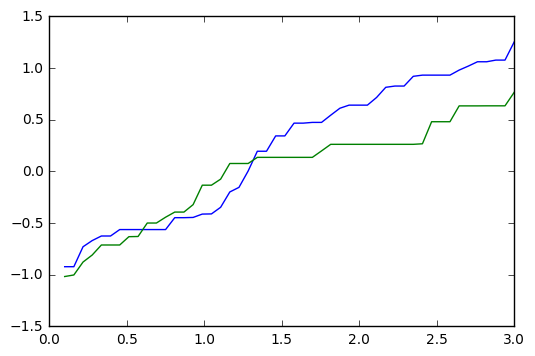

In [16]:
%matplotlib inline
pl.plot(grid, GP[0])

### Event time(s)

In [19]:
NHPP[0:10]

[array([ 2.93896875]),
 array([ 1.18416037,  1.28041521,  1.85658696]),
 array([ inf]),
 array([ 1.39165266,  1.82603355,  2.40293715,  2.60521368]),
 array([ 0.19285112,  2.07769919,  2.45857135,  2.90759715]),
 array([ 0.76449896,  0.94688525,  2.20919857,  2.24315376,  2.688542  ]),
 array([ 1.56536539,  2.54810694]),
 array([ 1.28753186,  1.70261277,  2.96494857]),
 array([ 0.17937234,  0.54691744]),
 array([ 0.53742563,  0.54677656,  0.77869911,  2.14771474])]

In [22]:
#np.mean(NHPP[:][0]) # how to deal with infinity ?

In [23]:
#np.std(NHPP[:][0])

### Plot baseline

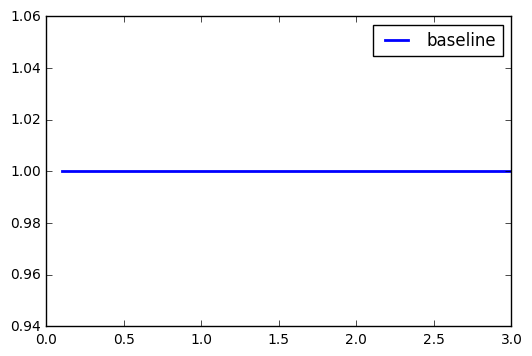

In [14]:
%matplotlib inline
pl.plot(grid, baseline, label="baseline", lw=2)
pl.legend()

### Plot coefficients

In [12]:
pl.axis([0, 3, -0.5, 1.5])
for j in range(len(beta)) :
    pl.plot(grid, beta[j], label="Beta" + str(j+1), lw=2)
pl.legend()

NameError: name 'beta' is not defined

In [22]:
grid = np.linspace(0.1,3,num=50)
beta = np.vstack([beta_piecewise_const(grid, param=(0.8,0.2,0.5)),
                  beta_piecewise_const(grid, param=(0.0,0.6,2.)),
                  beta_piecewise_const(grid, param=(-0.5,0.5,1.5))])

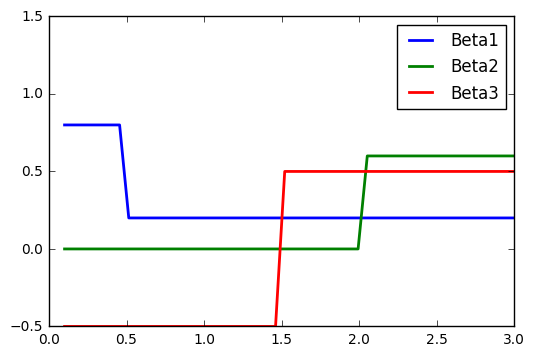

In [23]:
%matplotlib inline
pl.axis([0, 3, -0.5, 1.5])
for j in range(len(beta)) :
    pl.plot(grid, beta[j], label="Beta" + str(j+1), lw=2)
pl.legend()

## Plot $x_i$

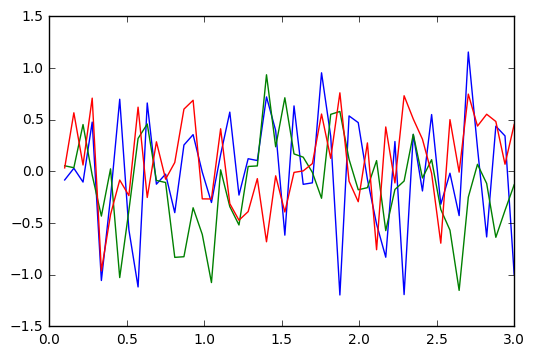

In [16]:
pl.plot(grid,X[0])

### Plot $x_i\beta$

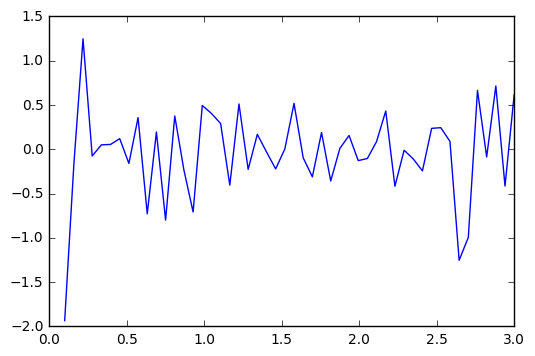

In [27]:
pl.plot(grid, f_xiBeta(X[0], beta, grid))

### Plot $e^{x_i\beta}$

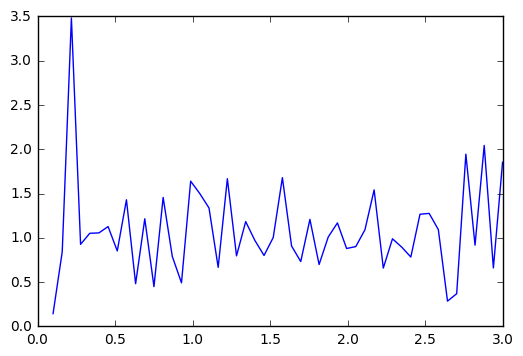

In [28]:
pl.plot(grid, np.exp(f_xiBeta(X[0], beta, grid)))

### plot $\lambda_i(t)$

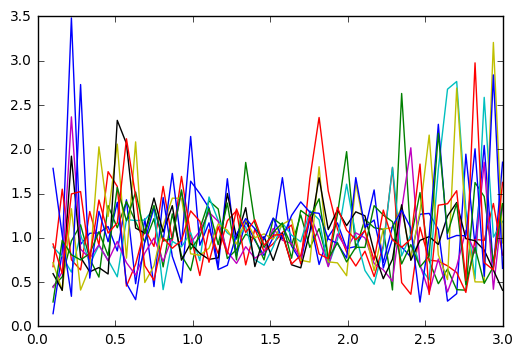

In [29]:
for i in range(min(n,10)):
    pl.plot(grid, lambda_i(baseline, X[i], beta, grid))